In [1]:
import numpy as np
from typing import List, Tuple
from tqdm import tqdm
from copy import deepcopy
from functools import cache
import random


# Ideas
# TODO: Validator for validating nonograms

# Hyperparameters:
# Gen:
# mutation_rate -> dynamic change?

# Solver:
# len_coefficient
# sum_coefficient
# population_size
# mutation_rate -> dynamic change
#
# generations
# improvement
# restarts

@cache
def get_bit(num: int, order: int) -> int:
    """
    Returns 'bit' of given number at 'order' position

    :param num:
    :param order:
    :return:
    """
    return (num >> order) & 1


@cache
def get_row(num: int, row_num: int, col: int, row: int) -> int:
    """
    Returns row of a given number in hte bit representation

    :param num:
    :param row_num:
    :param col:
    :param row:
    :return:
    """

    shift = col * (row - 1 - row_num)
    mask = (1 << col) - 1
    ans = ((num >> shift) & mask) | (1 << col)
    # print(bin(num), bin(mask), bin(ans))

    # 0b1 1011 1001 >> 4 | 1111  4 == col * (row - 1 - row_n)  4 == 4 * (1)
    # 0b1 1011 1011 >> 0 | 1111  0 == col * (row - 1 - row_n)  0 == 4 * (0)
    return ans


@cache
def get_col(num: int, col_num: int, col: int, row: int) -> int:
    """
    Returns column of a given number in the bit representation

    :param num:
    :param col_num:
    :param col:
    :param row:
    :return:
    """

    collected_col = 1
    shift = (col - col_num - 1)
    mask = (1 << shift)

    for i in range(row):
        r = get_row(num, i, col, row)
        collected_col = (collected_col << 1) | ((r & mask) >> shift)

    return collected_col


@cache
def update_row(cells: int, row_num: int, new_row: int, col: int, n: int) -> int:
    """
    Returns a bit string with row at 'row_num' replaced to 'new_row'

    :param cells:
    :param row_num:
    :param new_row:
    :param col:
    :return:
    """

    # print(bin(cells))
    cells_bits = list(bin(cells)[2:].zfill(n))
    new_row_bits = list(bin(new_row)[2:].zfill(col))

    new_row_bits.remove(new_row_bits[0])
    start_index = row_num * col + 1

    # print(cells_bits, new_row_bits)

    for i in range(col):
        cells_bits[start_index + i] = new_row_bits[i]

    # print(cells_bits)

    updated_cells_str = ''.join(cells_bits)

    ans = int(updated_cells_str, 2)

    # print(bin(ans), end="\n\n")

    return ans


@cache
def get_bits(cells, split_point: int):
    """
    Return bit string produced by splitting 'cells' at 'split_point'

    If point > 0:
        returns bits from cells in interval [0, point],
        first significant bit included

    if point < 0:
        return bits from cells in interval (point, end_of_cells]
        first significant bit included

    :param cells: the bit representation of gen.
    :param split_point: crossover point. Positive or negative value.
    :return: bit string of len point from cells.
    """

    if split_point > 0:
        return (cells >> split_point) << split_point
    return ((1 << abs(split_point)) - 1) & cells


class NanogramGen:
    def __init__(self,
                 rows: int, cols: int,
                 row_clues: List[List[int]], col_clues: List[List[int]],
                 mutation_rate: float = 0.5):
        """

        :param rows:
        :param cols:
        :param row_clues:
        :param col_clues:
        :param mutation_rate:
        """

        self.rows = rows  #
        self.cols = cols  #
        self.row_clues = row_clues  #
        self.col_clues = col_clues  #
        self.mutation_rate = mutation_rate  #
        self.n = self.rows * self.cols  # Size of grid in 'bits'
        self.cells = 1 << self.n  # TODO

    def __hash__(self):
        return hash(self.cells)

    def __generate_row(self, row_clues: List[int]) -> int:
        row = [0 for _ in range(self.cols)]

        i_position = []
        cursor = 0
        common_length = sum(row_clues)
        amount = len(row_clues)  # amount of strings
        n = amount

        for j in range(amount):
            index = np.random.randint(cursor, (self.cols - common_length - n + 2))
            i_position.append(index)
            for k in range(row_clues[j]):
                row[k + index] = 1
            common_length -= row_clues[j]
            cursor = (index + row_clues[j] + 1)
            n -= 1

        row_binary = '1' + ''.join(map(str, row))
        ans = int(row_binary, 2)

        # print(row, bin(ans))

        return ans

    def initialize(self):
        """

        :return: Returns Itself after being initialized
        """
        # print(self.cells)
        rows = []
        for row in range(self.rows):
            new_row = self.__generate_row(self.row_clues[row])
            rows.append(new_row)
            self.cells = update_row(cells=self.cells, col=self.cols, row_num=row, n=self.n, new_row=new_row)

        return self

    def mutate(self) -> None:
        """

        :return:
        """

        for row in range(self.rows):
            if np.random.rand() > self.mutation_rate:
                continue

            if str(get_row(self.cells, row, self.cols, self.rows)).count("1") == len(self.row_clues) - 1:
                continue

            new_row = self.__generate_row(self.row_clues[row])
            self.cells = update_row(cells=self.cells, col=self.cols, row_num=row, n=self.n, new_row=new_row)

    def show(self) -> None:
        """

        :return:
        """
        bits = str(bin(self.cells)[3:])
        print(bits)

        for i in range(self.rows):
            print()
            sub_str = bits[i * self.rows: i * self.rows + self.cols]
            for symbol in sub_str:
                if symbol == '1':
                    print("x", end=" ")
                else:
                    print(" ", end=" ")
        print()


class NonogramSolverGA:
    def __init__(
            self, rows: int, columns: int,
            row_clues: List[List[int]], col_clues: List[List[int]],
            population_size=100, mutation_rate=0.2, gen_mutation=0.2,
            len_coefficient=1, sum_coefficient=1
    ):
        """

        :param rows:
        :param columns:
        :param row_clues:
        :param col_clues:
        :param population_size:
        :param mutation_rate:
        """
        self.rows = rows
        self.columns = columns
        self.row_clues = row_clues
        self.col_clues = col_clues
        self.n = self.rows * self.columns

        # Hyperparameters
        self.len_coefficient = len_coefficient  # Coefficient for penalizing wrong number of segment
        self.sum_coefficient = sum_coefficient  # Coefficient for penalizing wrong number of points in the line

        self.mutation_rate = mutation_rate
        self.population_size = population_size

        # Check if constraints conflict with rows / cols
        self.__validator()

        # For fast creation of new NonogramGens
        self.__params = {
            "rows": self.rows,
            "cols": self.columns,
            "row_clues": self.row_clues,
            "col_clues": self.col_clues,
            "mutation_rate": gen_mutation
        }
        self.fitness_cache = {}

    def __validator(self):
        error = False
        if self.rows == 0:
            error = True
        if error:
            raise Exception("Constraints conflict with the size of rows / columns")

    def fitness(self, individual) -> int:  # lower -> better
        """
        :param individual:
        :return:
        """

        if individual.cells in self.fitness_cache:
            return self.fitness_cache[individual]

        col_errors = np.sum([
            self.__evaluate_line(
                get_col(num=individual.cells, col=self.columns, row=self.rows, col_num=i),
                self.col_clues[i])
            for i in range(0, self.columns)
        ])

        self.fitness_cache[individual] = col_errors

        return col_errors

    def __evaluate_line(self, line: int, clue: List[int]) -> int:
        """
        Evaluates given lines according to the given clue.

        :param line: binary representation of the line
        :param clue: list of integers representing clue for the line
        :return: possible penalty in interval [0, +inf)
        """

        string_parts = [non_empty for non_empty in bin(line)[3:].split(sep="0") if non_empty]

        parts = [len(i) for i in string_parts]

        if parts == clue:
            return 0

        a = abs(len(parts) - len(clue))
        b = abs(sum(parts) - sum(clue))

        return self.len_coefficient * a + self.sum_coefficient * b

    def __crossover(self, parent1: NanogramGen, parent2: NanogramGen) -> NanogramGen:
        """
        Perform crossover operation, crossing full rows

        :param parent1:
        :param parent2:
        :return:
        """
        # Apply crossover operation to produce offspring

        # Get a row number from witch we cross gen.
        # IMPORTANT: If the split in the middle of row, we get wrong (according to clues) child
        crossover_row = np.random.randint(1, self.rows)
        crossover_point = crossover_row * self.columns

        part1 = get_bits(parent1.cells, crossover_point)
        part2 = get_bits(parent2.cells, -crossover_point)

        child = NanogramGen(**self.__params)
        child.cells = part1 + part2

        return child

    def evolve(self, generations: int = 100,
               improvement: int = 50,
               return_fitness_change: bool = False,
               restarts: int = 5,
               stop_number=30,
               elite_coefficient=8
               ):
        """

        :param generations: maximal number of generations
        :param improvement: number of iterations with the same fitness. Influence mutation increase
        :param return_fitness_change: return an array of the best fitness for each generation
        :param restarts: Number of attempts to restart algorithm after reaching 'stop_number'
        :param stop_number: number of iterations with the same fitness. After reaching this value, stopping algorithm
        :param elite_coefficient: corresponds to elitism ratio
        :return: Solution of class NanogramGen
        """

        self.fitness_cache = {}
        rate_mut, gen_mut = self.mutation_rate, self.__params["mutation_rate"]

        def __run_attempt():

            population = [NanogramGen(**self.__params).initialize() for _ in range(self.population_size * 2)]

            # Evaluate fitness for each individual
            fitness_scores = [(individual, self.fitness(individual=individual)) for individual in population]
            fitness_scores.sort(key=lambda x: x[1])

            fitness_scores = fitness_scores[:self.population_size]

            not_improving = 0
            best_score = fitness_scores[0][1]

            fitness_change = []

            for _ in range(generations):
                # Select top individuals for reproduction (elitism)
                elite = [deepcopy(individual) for individual, _ in
                         fitness_scores[:self.population_size // elite_coefficient]]

                offsprings = []
                while len(offsprings) < self.population_size - len(elite):
                    parent1, parent2 = np.random.choice(population, size=2)
                    child = self.__crossover(parent1, parent2)
                    if np.random.rand() < self.mutation_rate:
                        child.mutate()
                    offsprings.append(child)

                population = elite + offsprings

                # Evaluate fitness for each individual
                fitness_scores = [(individual, self.fitness(individual=individual)) for individual in population]
                fitness_scores.sort(key=lambda x: x[1])

                fitness_change.append(fitness_scores[0][1])

                # Stooping if we found solution
                if fitness_scores[0][1] == 0:
                    break

                # Early stopping criteria

                if best_score == fitness_scores[0][1]:
                    not_improving += 1
                else:
                    not_improving = 0
                    self.mutation_rate, self.__params["mutation_rate"] = rate_mut, gen_mut

                best_score = min(best_score, fitness_scores[0][1])

                if not_improving == improvement * 2:
                    self.__params["mutation_rate"] += 0.1
                    self.mutation_rate += 0.1

                if not_improving == improvement * 3:
                    self.__params["mutation_rate"] += 0.2
                    self.mutation_rate += 0.2

                if not_improving == improvement * 5:
                    self.__params["mutation_rate"] = 1
                    self.mutation_rate = 1

                if not_improving == stop_number:
                    print(f"The fittness does not improve for {not_improving} iterations.")
                    break

            return [fitness_scores[0][0], fitness_change]

        best_sol = (None, None)

        for r_i in tqdm(range(restarts)):
            self.mutation_rate, self.__params["mutation_rate"] = rate_mut, gen_mut
            solution, fitness_change = __run_attempt()

            print(f"Iteration {r_i + 1}/{restarts}. Restarting algo. Best solution: {fitness_change[-1]}")
            if best_sol == (None, None) or best_sol[1][-1] > fitness_change[-1]:
                best_sol = (solution, fitness_change)

            if fitness_change[-1] == 0:
                break

        # create an object with all requested outputs
        to_return = [best_sol[0]]
        if return_fitness_change:
            to_return.append(best_sol[1])

        self.fitness_cache = {}

        return to_return


def plot_fitness(fitness: List[float], plot_size: Tuple[float, float] = (16, 9)) -> None:
    import matplotlib.pyplot as plt

    plt.figure(figsize=plot_size)
    plt.plot(fitness, label="Fitness change")
    plt.xlabel("Generation number")
    plt.ylabel("Fitness score")
    plt.title("Fitness change of best Gen over generations")
    plt.legend(loc="best")
    plt.show()

In [2]:
params_solver = {
    "population_size": 100,
    "mutation_rate": 0.2,
    "gen_mutation": 0.1,
    "sum_coefficient" : 1,
    "len_coefficient": 1
}

params_evolve = {
    "generations": 400,
    "improvement": 4,
    "restarts": 10,
    "return_fitness_change": True,
    "stop_number" : 50,
    "elite_coefficient": 10
}

  0%|          | 0/10 [00:00<?, ?it/s]

Iteration 1/10. Restarting algo. Best solution: 0
Solution: 1394363494684507292187537797464
Fitness: 0
0001100110010110111001110011000111001001001000110110100111111111111111111110011101010111000101011000

      x x     x x   
  x   x x   x x x   
  x x x     x x     
  x x x     x     x 
    x       x x   x 
x   x     x x x x x 
x x x x x x x x x x 
x x x x x     x x x 
  x   x   x x x     
  x   x   x x       


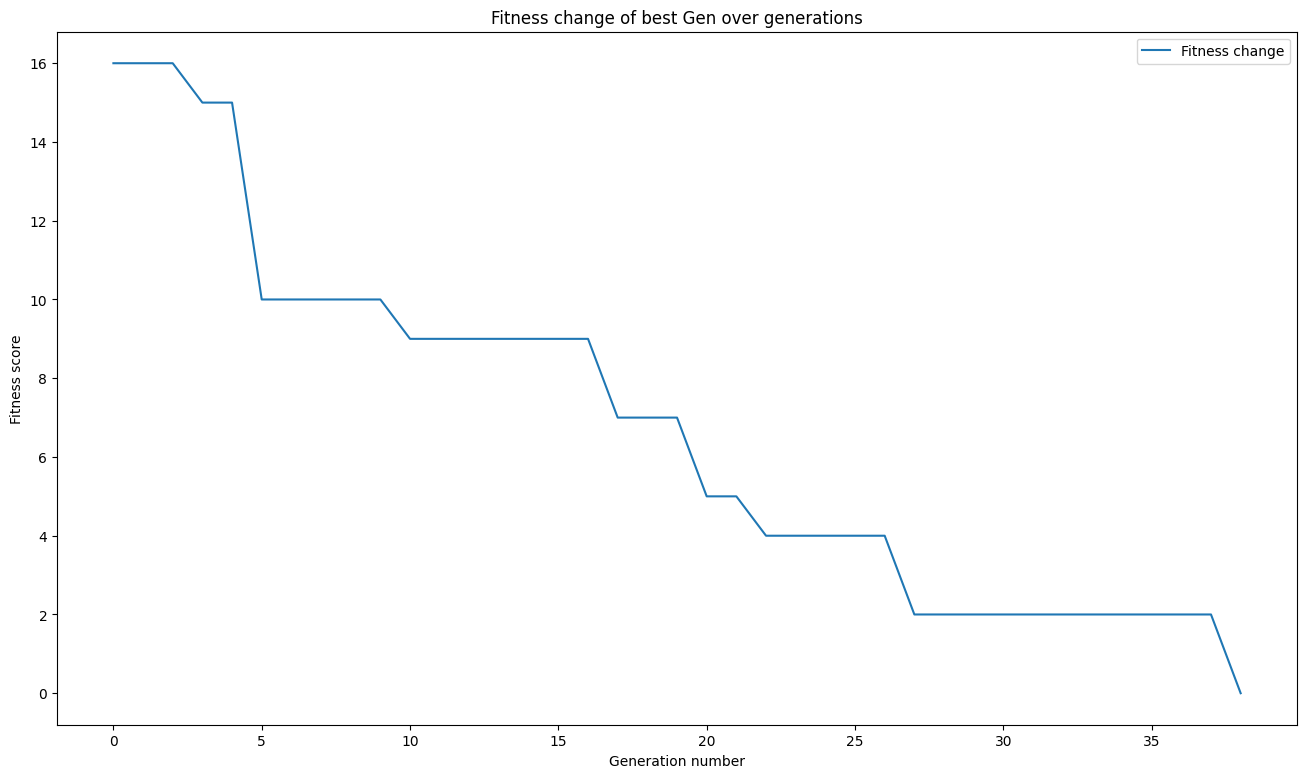

In [3]:
# test 1
col_clues = [[3], [3, 4], [6], [4, 4], [2, 2], [2, 2], [6, 2], [3, 5], [2, 3], [5]]
row_clues = [[2, 2], [1, 2, 3], [3, 2], [3, 1, 1], [1, 2, 1], [1, 1, 5], [10], [5, 3], [1, 1, 3], [1, 1, 2]]
rows = len(row_clues)
columns = len(col_clues)

solver = NonogramSolverGA(rows=rows, columns=columns, row_clues=row_clues, col_clues=col_clues, **params_solver)

solution, fitness_change = solver.evolve(**params_evolve)

print(f"Solution: {solution.cells}\nFitness: {fitness_change[-1]}")
solution.show()
plot_fitness(fitness_change)

 10%|█         | 1/10 [00:01<00:13,  1.49s/it]

The fittness does not improve for 50 iterations.
Iteration 1/10. Restarting algo. Best solution: 13


 20%|██        | 2/10 [00:02<00:11,  1.38s/it]

The fittness does not improve for 50 iterations.
Iteration 2/10. Restarting algo. Best solution: 14


 30%|███       | 3/10 [00:04<00:09,  1.35s/it]

The fittness does not improve for 50 iterations.
Iteration 3/10. Restarting algo. Best solution: 9
The fittness does not improve for 50 iterations.
Iteration 4/10. Restarting algo. Best solution: 13


 50%|█████     | 5/10 [00:06<00:06,  1.33s/it]

The fittness does not improve for 50 iterations.
Iteration 5/10. Restarting algo. Best solution: 14


 60%|██████    | 6/10 [00:08<00:05,  1.37s/it]

The fittness does not improve for 50 iterations.
Iteration 6/10. Restarting algo. Best solution: 14


 70%|███████   | 7/10 [00:09<00:04,  1.41s/it]

The fittness does not improve for 50 iterations.
Iteration 7/10. Restarting algo. Best solution: 15


 80%|████████  | 8/10 [00:11<00:02,  1.42s/it]

The fittness does not improve for 50 iterations.
Iteration 8/10. Restarting algo. Best solution: 15
The fittness does not improve for 50 iterations.
Iteration 9/10. Restarting algo. Best solution: 14


100%|██████████| 10/10 [00:13<00:00,  1.35s/it]

The fittness does not improve for 50 iterations.
Iteration 10/10. Restarting algo. Best solution: 20
Solution: 59828905335795074984901429983551292989677132452884007723354545061887
Fitness: 9
000111000000111000000001100110010001111001000011011111100110010111111100010100111111110010110111111111011110011111101011011000111110011111001101001110111101110011100111111111111100111111111111001111111111100011111111111111111

      x x x             x x x 
                x x     x x   
  x       x x x x     x       
  x x   x x x x x x     x x   
  x   x x x x x x x       x   
x     x x x x x x x x     x   
x x   x x x x x x x x x   x x 
x x     x x x x x x   x   x x 
  x x       x x x x x     x x 
x x x     x x   x     x x x   
x x x x   x x x     x x x     
x x x x x x x x x x x x x     
x x x x x x x x x x x x     x 
x x x x x x x x x x       x x 
x x x x x x x x x x x x x x x 


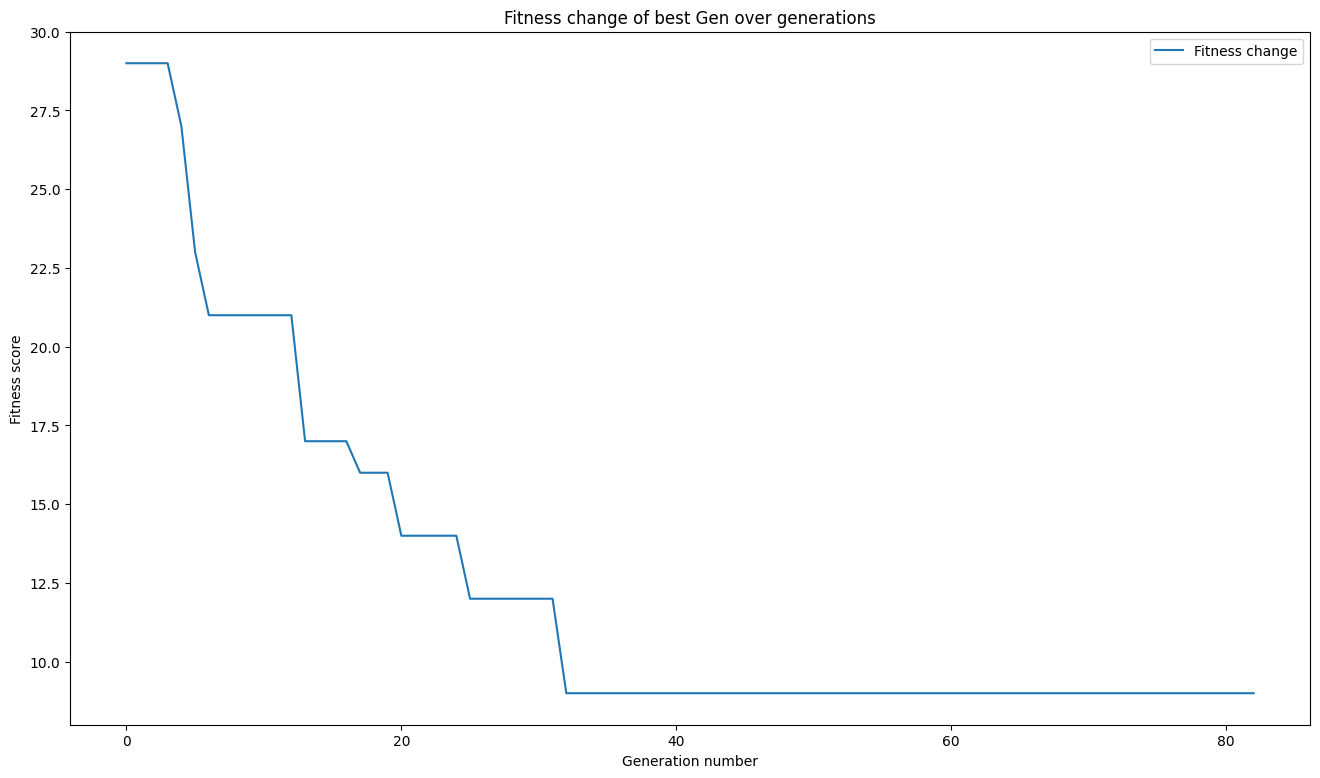

In [4]:
# Test 2

col_clues = [[9], [12], [3, 6], [2, 2, 5], [1, 5, 4],
             [1, 8, 4], [13], [7, 5], [7, 5], [1, 7, 4],
             [1, 3, 2, 1], [2, 2, 3, 1], [3, 3, 1], [8, 2], [4, 3]]
row_clues = [[3, 3], [2, 2], [1, 4, 1], [2, 6, 2], [1, 7, 1],
             [1, 8, 1], [2, 9, 2], [2, 6, 1, 2], [2, 5, 2], [3, 2, 1, 3],
             [4, 3, 3], [13], [12, 1], [10, 2], [15]]

rows = len(row_clues)
columns = len(col_clues)

solver = NonogramSolverGA(rows=rows, columns=columns, row_clues=row_clues, col_clues=col_clues, **params_solver)

solution, fitness_change = solver.evolve(**params_evolve)

print(f"Solution: {solution.cells}\nFitness: {fitness_change[-1]}")
solution.show()
plot_fitness(fitness_change)

 10%|█         | 1/10 [00:01<00:15,  1.70s/it]

The fittness does not improve for 50 iterations.
Iteration 1/10. Restarting algo. Best solution: 15


 20%|██        | 2/10 [00:03<00:13,  1.66s/it]

The fittness does not improve for 50 iterations.
Iteration 2/10. Restarting algo. Best solution: 13


 30%|███       | 3/10 [00:05<00:12,  1.78s/it]

The fittness does not improve for 50 iterations.
Iteration 3/10. Restarting algo. Best solution: 11


 40%|████      | 4/10 [00:07<00:10,  1.78s/it]

The fittness does not improve for 50 iterations.
Iteration 4/10. Restarting algo. Best solution: 12


 60%|██████    | 6/10 [00:10<00:06,  1.63s/it]

The fittness does not improve for 50 iterations.
Iteration 5/10. Restarting algo. Best solution: 9
The fittness does not improve for 50 iterations.
Iteration 6/10. Restarting algo. Best solution: 14


 80%|████████  | 8/10 [00:13<00:03,  1.77s/it]

The fittness does not improve for 50 iterations.
Iteration 7/10. Restarting algo. Best solution: 16
The fittness does not improve for 50 iterations.
Iteration 8/10. Restarting algo. Best solution: 8


100%|██████████| 10/10 [00:17<00:00,  1.80s/it]

The fittness does not improve for 50 iterations.
Iteration 9/10. Restarting algo. Best solution: 12
The fittness does not improve for 50 iterations.
Iteration 10/10. Restarting algo. Best solution: 6


100%|██████████| 10/10 [00:17<00:00,  1.75s/it]

Solution: 106156422701078731735544097106645697842612605210378735727190645088254
Fitness: 6
111110000000000111111100000000111111111000000111001111001000110001110001011110110100011111110011111111111110011111111111111011101011111111111001000011011111000000010011111100000010111111100000110111111111001110001111111111110

x x x x x                     
x x x x x x x                 
x x x x x x x x x             
x x x     x x x x     x       
x x       x x x       x   x x 
x x   x x   x       x x x x x 
x x     x x x x x x x x x x x 
x x     x x x x x x x x x x x 
x x x   x x x   x   x x x x x 
x x x x x x     x         x x 
  x x x x x               x   
  x x x x x x             x   
x x x x x x x           x x   
x x x x x x x x x     x x x   
    x x x x x x x x x x x x   


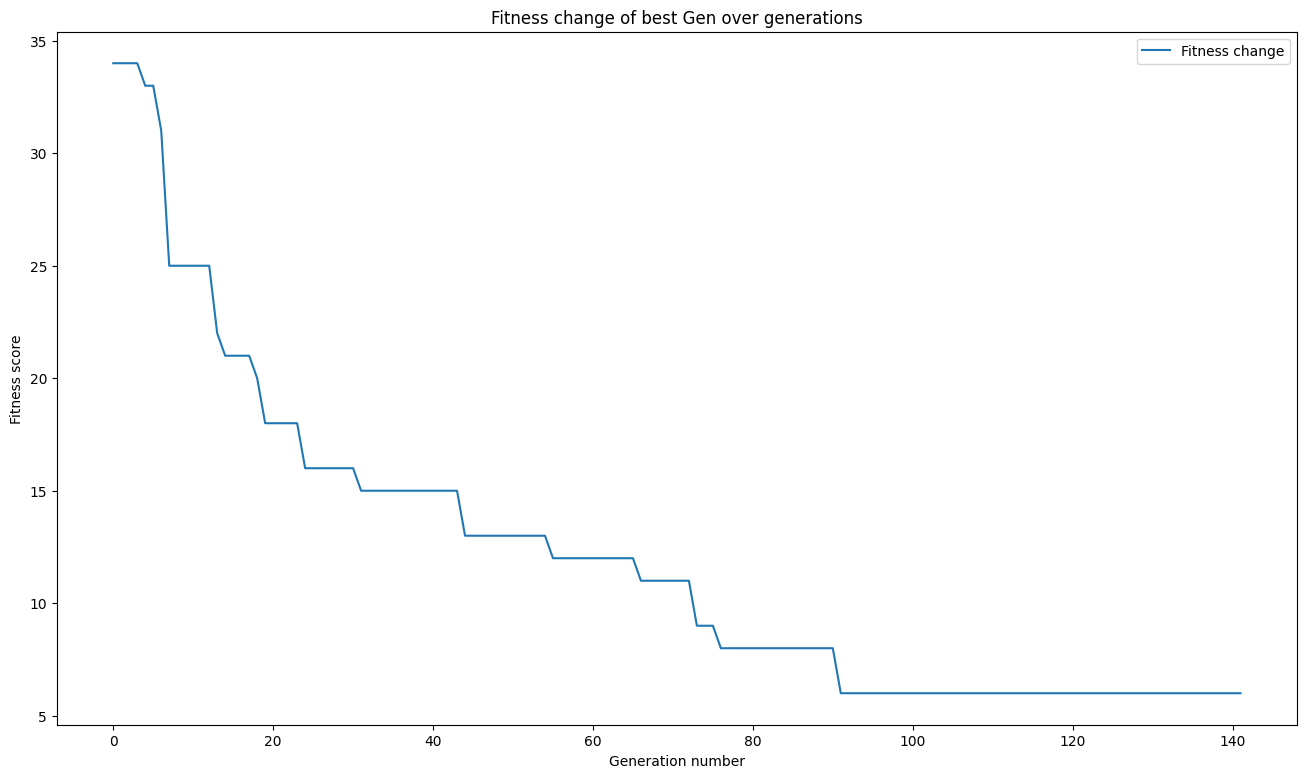

In [5]:
# Test 3
col_clues = [[12], [14], [4, 7], [3, 6], [5, 9],
             [10, 4], [9, 3], [3, 2, 2], [1, 4, 2], [2, 1],
             [4, 1], [6, 2], [4, 3], [11], [6]]
row_clues = [[5], [7], [9], [3, 4, 1], [2, 3, 1, 2],
             [2, 2, 1, 5], [2, 11], [2, 11], [3, 3, 1, 5], [6, 1, 2],
             [5, 1], [6, 1], [7, 2], [9, 3], [12]]

rows = len(row_clues)
columns = len(col_clues)

solver = NonogramSolverGA(rows=rows, columns=columns, row_clues=row_clues, col_clues=col_clues, **params_solver)

solution, fitness_change = solver.evolve(**params_evolve)

print(f"Solution: {solution.cells}\nFitness: {fitness_change[-1]}")
solution.show()
plot_fitness(fitness_change)

 10%|█         | 1/10 [00:01<00:11,  1.29s/it]

The fittness does not improve for 50 iterations.
Iteration 1/10. Restarting algo. Best solution: 6


 20%|██        | 2/10 [00:02<00:10,  1.31s/it]

The fittness does not improve for 50 iterations.
Iteration 2/10. Restarting algo. Best solution: 6


 30%|███       | 3/10 [00:03<00:07,  1.11s/it]

The fittness does not improve for 50 iterations.
Iteration 3/10. Restarting algo. Best solution: 6


 40%|████      | 4/10 [00:04<00:07,  1.25s/it]

The fittness does not improve for 50 iterations.
Iteration 4/10. Restarting algo. Best solution: 8


 50%|█████     | 5/10 [00:06<00:06,  1.24s/it]

The fittness does not improve for 50 iterations.
Iteration 5/10. Restarting algo. Best solution: 11


 60%|██████    | 6/10 [00:07<00:04,  1.15s/it]

The fittness does not improve for 50 iterations.
Iteration 6/10. Restarting algo. Best solution: 10


 70%|███████   | 7/10 [00:08<00:03,  1.26s/it]

The fittness does not improve for 50 iterations.
Iteration 7/10. Restarting algo. Best solution: 5


 80%|████████  | 8/10 [00:09<00:02,  1.12s/it]

The fittness does not improve for 50 iterations.
Iteration 8/10. Restarting algo. Best solution: 13


 90%|█████████ | 9/10 [00:10<00:01,  1.15s/it]

The fittness does not improve for 50 iterations.
Iteration 9/10. Restarting algo. Best solution: 12


100%|██████████| 10/10 [00:12<00:00,  1.21s/it]

The fittness does not improve for 50 iterations.
Iteration 10/10. Restarting algo. Best solution: 7


100%|██████████| 10/10 [00:12<00:00,  1.20s/it]

Solution: 2258663426425162392254366318784
Fitness: 5
1100100000100010001010011000101111000010111110001011001111110000110010111110000010111000000011000000

x x     x           
x       x       x   
x     x x       x   
x x x x         x   
x x x x x       x   
x x     x x x x x x 
        x x     x   
x x x x x           
x   x x x           
    x x             


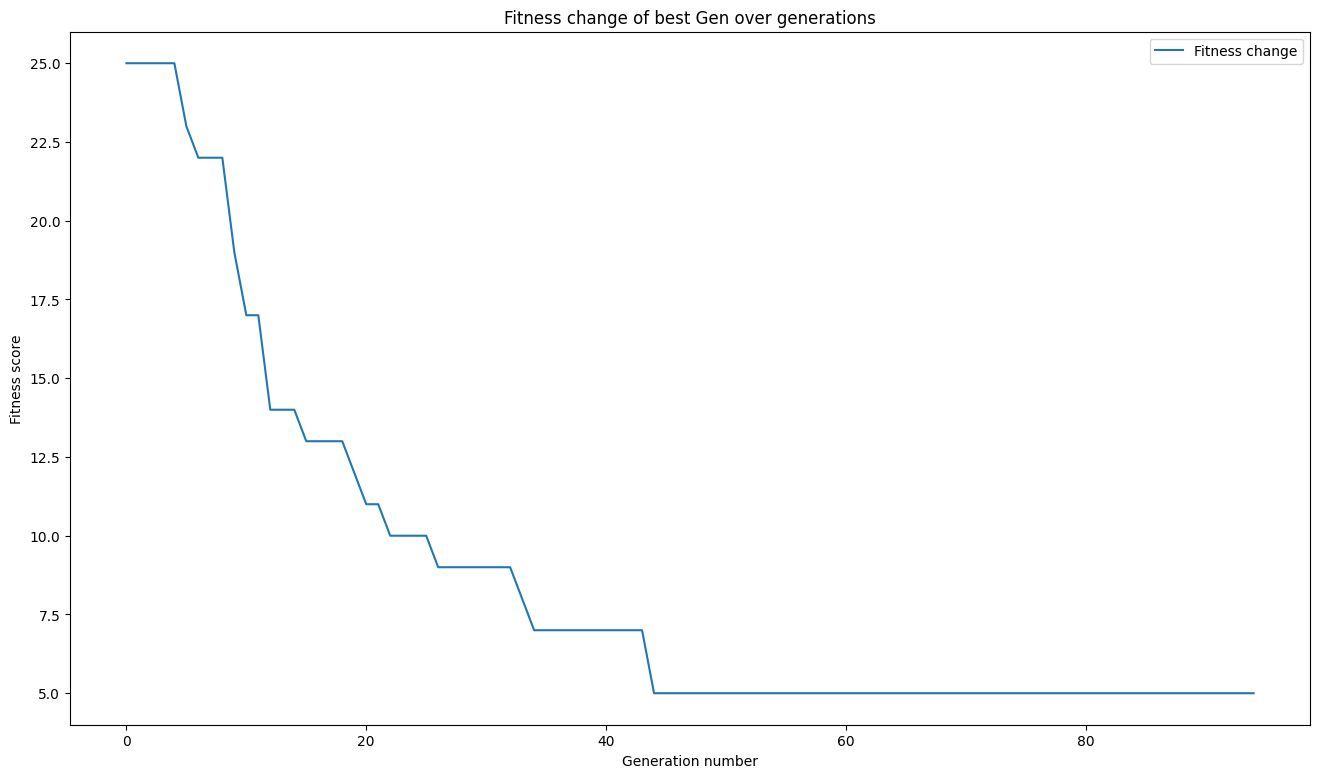

In [6]:
# Test 4
col_clues = [[6, 2], [1, 3, 1], [4, 2], [3, 3], [6], [2], [1], [1], [7], [1]]
row_clues = [[2, 1], [1, 1, 1], [1, 2, 1], [4, 1], [5, 1], [2, 6], [2, 1], [5], [1, 3], [2]]

rows = len(row_clues)
columns = len(col_clues)

solver = NonogramSolverGA(rows=rows, columns=columns, row_clues=row_clues, col_clues=col_clues, **params_solver)

solution, fitness_change = solver.evolve(**params_evolve)

print(f"Solution: {solution.cells}\nFitness: {fitness_change[-1]}")
solution.show()
plot_fitness(fitness_change)